# Group 10 - First Year Project
### Data Science at ITU 
## Project 2 - Correlation between Covid-19's spread and weather conditions

Introduction

This notebook contains all the code developed in the Project 2 - Correlation between Covid-19's spread and weather conditions

Contact/Group: 
- Florian Micliuc(flmi@itu.dk)
- Louis Caspar Brandt (locb@itu.dk)
- Iben Mai Huse (ibhu@itu.dk)
- Katalin Literati-Dobos (klit@itu.dk)
- Ruben Jonsman (rubj@itu.dk)

#  Library imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from folium.features import DivIcon
import imageio

# Functions

In [2]:
def check_null_values(file, string):
    if file.isnull().values.any():
        print('There are null values in {} dataset'.format(string))
    else:
        print('There are no null values in {} dataset'.format(string))

In [3]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

In [4]:
def weather_mean_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title('Mean of' + ' '+ column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [5]:
def corona_total_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [142]:
def corona_line_plot(df,x,y,title):
    ax = df.plot.line(x = x, y = y,rot = 45,figsize = (20,6),color = 'silver')
    ax.set_title(title)
    ax.set_ylabel("Covid-19 Cases")
    ax.set_xlabel("Date")
    plt.axvline(x='2020-03-15',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-03-22',color = '#f00008',ls = '--');
    plt.axvline(x='2020-04-15',color = 'blue',ls = '--');
    plt.axvline(x='2020-11-02',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-12-15',color = '#f00008',ls = '--');
    plt.axvline(x='2020-12-26',color = '#00ff68',ls = '--');

In [136]:
def corona_bar_plot(x,y,title):
    fig = plt.figure(figsize=(20,6))
    axes = fig.add_axes([0,0,1,1])
    axes.bar(x, y,color = 'silver')
    axes.set_title(title)
    axes.set_ylabel("Covid-19 Cases")
    axes.set_xlabel("Date")

In [56]:
def pearson_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [62]:
def spearman_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = spearmanr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [89]:
def pearson_log(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(np.log(df[column]), df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

# Task 0 - Data cleaning and filtering

## Loading data

The data was loaded by creating a small pipeline to keep track of files and locations, in case they would change. This approach made it easy to change file locations if needed.

In [7]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]

The dates is parsed in the data, so that it has a consistent form. The data is tab seperated and thus we load the data with a tab seperator. We also append the extra data that was provided to our original weather data frame.

In [8]:
raw_data = {}

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['de_corona'] = pd.read_csv(corona, sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\t', parse_dates=['date'], date_parser=dateparse)
additional = pd.read_csv('../Data/Raw/weather/weather2.csv', sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = raw_data['weather'].append(additional)

with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.loads(f.read())

In [9]:
HEADERS = ['de_corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

de_corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (20220, 9)


## Data type insight

With the data provided involved the following fields: 

In [10]:
list(raw_data["weather"].columns), list(raw_data["de_corona"].columns)

(['date',
  'iso3166-2',
  'RelativeHumiditySurface',
  'SolarRadiation',
  'Surfacepressure',
  'TemperatureAboveGround',
  'Totalprecipitation',
  'UVIndex',
  'WindSpeed'],
 ['date', 'region_code', 'confirmed_addition', 'deceased_addition'])

The following fields are categorical variables:
- iso3166-2 (the codes of the regions in Germany)
- date
- region_code (the name of the region)

The following fields are numerical variables:
- RelativeHumiditySurface 
- SolarRadiation
- Surfacepressure 
- TemperatureAboveGround (measured in Kelvin)
- Totalprecipitation
- UVIndex (1-10)
- Windspeed (m/s)
- confirmed_addition (number of confirmed Covid-19 infections)
- deceased_addition (number of deceased with a confirmed Covid-19 infections)

All the weather data is a 24-hour sum of the day, which will result in higher than expected values, these variables can be divided by 24 to get the mean of the day, though this will also be flawed data, since the data will have a daily mean. SolarRadiation, UVIndex is only relevent when the sun is actually present during the day, by getting the daily mean, the hours of the day where the sun is not active is taken into account, which results in lower than expected values. 

## Filtering the weather dataset

Our assigned country in this project is Germany and thus we filter the data so that we only have data from Germany

In [11]:
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
weather_data_de.reset_index(drop=True, inplace=True)
processed_data = {}
processed_data["weather"] = weather_data_de
processed_data["weather"].to_csv("../Data/Processed/processed_weather.csv")
processed_data["de_corona"] = raw_data["de_corona"]

## Relational data table needed?
#Description

## Sanity check

Here we check for typical issues with raw data. We are checking for missing data, duplicate data and null values.

### Check for null values

In [12]:
check_null_values(raw_data['de_corona'], "de_corona")
check_null_values(weather_data_de, "weahter_data_de")

There are no null values in de_corona dataset
There are no null values in weahter_data_de dataset


### Checking and visualizing for weird values

In [13]:
#dataset_checker_values(weather_data_de,-999) #-999

In [14]:
#dataset_checker_values(weather_data_de,-1) #-1

In [15]:
#dataset_checker_values(raw_data['de_corona'],-999) #-999

In [16]:
#dataset_checker_values(raw_data['de_corona'],-1) #-1

### Checking for duplicates

In [17]:
if True in list(raw_data["de_corona"].duplicated()):
    print("Duplicate rows")
else: 
    print("No duplicate rows")

No duplicate rows


# Task 1 - Single Variable Analysis

In [18]:
#similar to how Michele did, creating the corona dataset with the regions
corona_df = raw_data['de_corona']
ss = dict()
for i in country_metadata['country_metadata']:
    ss[i['covid_region_code']] = i['iso3166-2_code']
corona_df['region'] = corona_df['region_code'].map(ss)
#corona_df

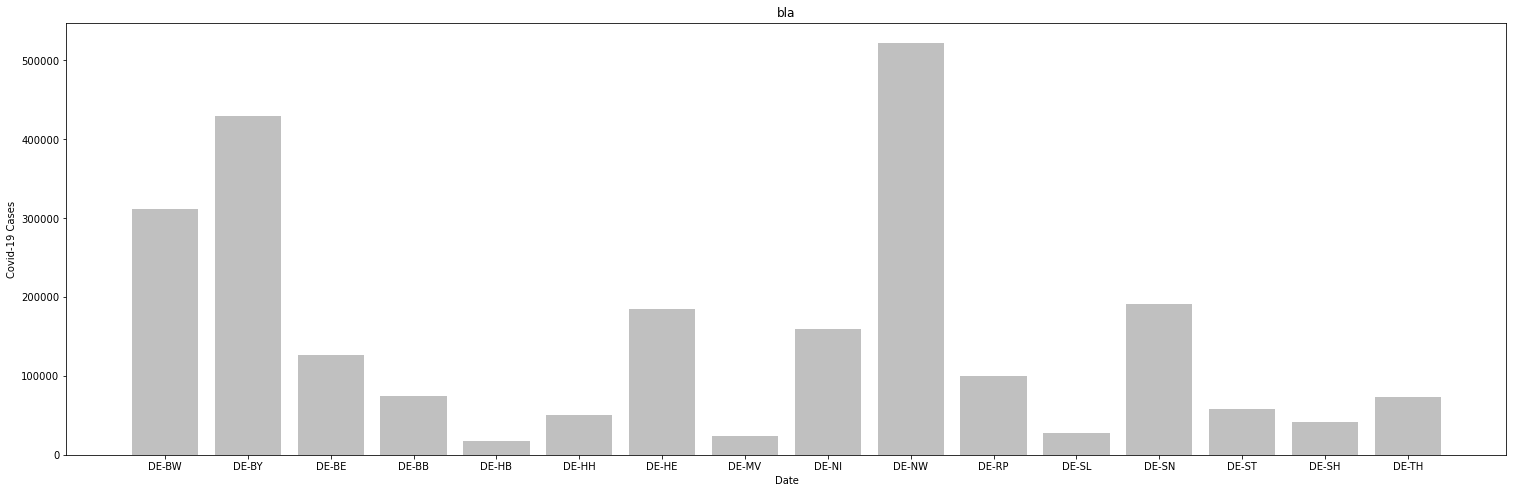

In [154]:
#total  of covid cases per region
meta_df = pd.DataFrame(country_metadata['country_metadata'])
sorted_country_metadata = meta_df.sort_values(by = 'iso3166-2_name_en')
corona_by_region  = pd.DataFrame(raw_data['de_corona'].groupby(by = 'region_code').sum())
corona_by_region['iso3166-2_code'] = sorted_country_metadata['iso3166-2_code'].values
corona_by_region['population'] = sorted_country_metadata['population'].values
#corona_bar_plot(corona_by_region['iso3166-2_code'],corona_by_region['confirmed_addition'],'bla') potential use

In [20]:
#merging the corona dataset with the weather dataset for future associations. 
daily_corona_weather = corona_df.merge(weather_data_de, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
daily_corona_weather = daily_corona_weather.drop(["date", "region_code", "region"], axis = 1)
#daily_corona_weather

## Monthly Analysis

In [21]:
weather_date = pd.to_datetime(weather_data_de['date'])
weather_2020=pd.DataFrame(weather_data_de[weather_date.dt.year == 2020])
weather_2021=pd.DataFrame(weather_data_de[weather_date.dt.year == 2021])

weather_month_2020 = pd.DataFrame(weather_2020.groupby(weather_date.dt.month).mean())
weather_month_2021 = pd.DataFrame(weather_2021.groupby(weather_date.dt.month).mean())
right_weather_one = weather_month_2020.append(weather_month_2021)
celsius = pd.DataFrame(weather_data_de['TemperatureAboveGround'].subtract(273.15))
right_weather_one['Temp_Celsius'] = celsius
#right_weather_one

In [22]:
#weather_mean_bar_plot('SolarRadiation',right_weather_one)

In [113]:
corona_date = pd.to_datetime(raw_data['de_corona']['date'])
corona_2020=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2020])
corona_2021=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2021])

corona_2021_month_sum = pd.DataFrame(corona_2021.groupby(corona_date.dt.month).sum())
corona_month_sum = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).sum())
corona_month_mean = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).mean())
right_one = corona_month_sum.append(corona_2021_month_sum)
#right_one

In [24]:
#corona_total_bar_plot('confirmed_addition',right_one[1:])

In [25]:
#corona_total_bar_plot('deceased_addition',right_one[1:])

## Region and Weather Mean

In [26]:
weather_by_region = pd.DataFrame(weather_data_de.groupby(by = 'iso3166-2').mean())
#weather_by_region

# Task 2 - Associations

## Daily Associations

In [27]:
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Temp_Celsius']
significance_threshold = 0.001 / (len(weather_headers) * 3)
daily_corona_weather['Temp_Celsius'] = celsius

### Pearson association for daily_corona_weather for original dataset

In [71]:
#pearson_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### Spearman association for daily_corona_weather for original dataset.

In [70]:
#spearman_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### Pearson asscociation for daily_corona_weather, with logtransformation of confirmed_addition

In [69]:
#pearson_log(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### sm.ols (Least Squares) multivariate regression

Values here may be misleading. This is because the multivariate regression, when looking at specific variables, it keeps all the other variables constant.

In [73]:
df = sm.add_constant(daily_corona_weather)
weather_headers.extend(["const"])

est = sm.OLS(df["confirmed_addition"], df[weather_headers], hasconst = True).fit()
#print(est.summary())

Here TemperatureAboveGround is a misleading variable, since in the previous sections we analysed that having a higher temperature leads to fewer cases. Though in this multiplevariate regression it is found out that a higher temperature increases the number of cases, this contradicts all prior analysis. The reason for this is that the multivariate regression keeps all other variables constant. That is, a day with the exact same weather conditions, besides the temperature being higher, will lead to more cases. To this there could be multiple reasons for this to occur, though a major and probable reason could be that people go outside during high temperatures, which in turn will lead to people not being isolated and thus there will be a higher probability of people getting a Covid-19 infection. 

Thus all these weather variables lead to change in human behavior, which results in changes in the amount of Covid-19 cases.

In [74]:
est = sm.OLS(df["deceased_addition"], df[weather_headers], hasconst = True).fit()
#print(est.summary())

All the weather variables does not result in anything interesting to be discorvered. From the multivariate regression it is apparent that more people die, with a covid-19 infection, during higher solar radiation. It also shows that fewer people die when the total precipitation is higher. Intuitively these variables does change the human behavior, but in no way that would cause them to reduce or increase the number of deaths caused by covid-19. Also the people dying of Covid-19 is most likely in a hospital bed and is under extensive care, thus intuitively these weather variables would not lead to changes in covid-19 deaths. 

The only explanation would be that the hospital care is worsened during good weather and better during poor weather. Which also does not make much sense intuitively.
   

## Monthly Associations

In [52]:
#corona and weather conditions grouped by months
df_monthly_sum = corona_month_sum.merge(weather_month_2020,left_on = 'date',right_on = 'date')

In [53]:
significance_threshold_monthly = 0.5 / (len(weather_headers) * 3)
weather_headers_month = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']
print(significance_threshold_monthly)

0.020833333333333332


Here the significance threshhold is increased due to the grouping of the data into months. This means that the breakpoint of where a variable is as not being correlated by chance is higher, which means that the certainty that the variable is a correlated by chance is less precise. 

#### Corona Cases per Month

In [80]:
#pearson_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

In [78]:
#spearman_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

In [79]:
#pearson_log(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

From these multivariate regressions it is apparent from the pearson that there is a correlation between the monthly total of Covid-19 cases and RelativeHumiditySurface, SolarRadiation and UVIndex. These variables tend to be higher during the summer, where there was a decrease in Covid-19 cases, thus this makes sense. Though in the spearman there is also seen high correlations, though the p-value is too high for us to assume that it has not happend by chance.

#### Corona Deaths per month

In [88]:
#pearson_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

In [87]:
#spearman_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

In [86]:
#pearson_log(df_monthly_sum[1:],'deceased_addition',weather_headers_month,significance_threshold_monthly) #interesting, check temperature above ground

The analysis of the corona cases/deaths per month could be interesting when it is analyzed how infectious one strain is from another. This would be quite hard to do daily because there is really hard that 1st of February 2020 would have the same weather conditions as 1st of February 2021. Therefore, there is a higher chance that the overall weather conditions in February 2020 to be the similar to February 2021.

### Dummy Variable Analysis

In [91]:
corona_df['Lockdown'] = 'False'
corona_df.loc[(corona_df["date"] >= "2020-11-02") & (corona_df["date"] <= "2021-03-07"), "Lockdown"] = 'True'

In [132]:
#data taken from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Germany - Government Reactions
mask = (corona_df['date'] > "2020-11-02") & (corona_df['date'] <= "2021-03-07")
corona_daily_sum = corona_df.groupby(corona_df['date']).sum().reset_index()
corona_daily_sum_lockdown = corona_df[mask].groupby(corona_df[mask]['date']).sum().reset_index()

In [150]:
#corona_line_plot(corona_daily_sum,'date','confirmed_addition','Corona lockdown plot')

In [149]:
#corona_line_plot(corona_daily_sum,'date','deceased_addition','Corona lockdown plot')

Data taken from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Germany - Government Reactions

- 15th March, borders to Austria, Denmark, France, Luxembourg and Switzerland were closed (light-red)
- 22nd March, curfews were imposed in six German states while other states prohibited physical contact with more than one person from outside one's household. (dark-red)
- 15th April loosening of restrictions (blue)
- 2nd November a partial lockdown was implemented, in which physical distancing rules were tightened while schools and kindergartens remained open, only temporarily halted the rise in case numbers (light-red)
- 15th December a hard lockdown was implemented (dark-red)
- 26th December 2020 - Vaccinations with the BioNTech–Pfizer COVID-19 vaccine began  (green)

In [148]:
#corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['confirmed_addition'],'Corona Lockdown Cases')

In [147]:
#corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['deceased_addition'],'Corona lockdown plot')

In [ ]:
x = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Lockdown']
#est1 = sm.OLS(np.log(df1["confirmed_addition"]), df1[x], hasconst = True).fit() #to do

# Task 3 - Map visualization

In [ ]:
# First task, we need to convert the region names in the corona data with the iso3166-2 codes
# To do so, first we need a dictionary mapping the region name to the code
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

# Then, we use the Series.map function
raw_data["de_corona"]["region"] = raw_data["de_corona"]["region_code"].map(region_map)

# Second task, we can now calculate how many cases there were in total for the region
corona_df_by_region = raw_data["de_corona"].groupby(by = "region")["confirmed_addition"].sum().reset_index()
dead_by_region      = raw_data["de_corona"].groupby(by = "region")["deceased_addition"].sum().reset_index()
# If we want to add population data, we need to create another dictionary from the country metadata
# In this case, we need to map from the region iso3166-2 code to the region's population
population_map = {
    country_metadata["country_metadata"][i]["iso3166-2_code"]: 
    country_metadata["country_metadata"][i]["population"] 
    for i in range(len(country_metadata["country_metadata"]))}

# Then we can map, just like before
corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)

corona_df_by_region["ratio"] = corona_df_by_region["confirmed_addition"]/corona_df_by_region["population"]

## Total number of Cases of Covid-19 on a regional basis

In [ ]:
n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_df_by_region,
    columns = ["region", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Cases of Covid-19").add_to(n_cases)
n_cases

## Total number of deceased with a confirmed Covid-19 infection on a regional basis

In [ ]:
dead = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = dead_by_region,
    columns = ["region", "deceased_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "Greys", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Deceased with an covid-19 infection").add_to(dead)
dead

## Population on a regional basis 

In [ ]:
p_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
folium.Choropleth(
    geo_data = shape,
    name = "population",
    data = corona_df_by_region,
    columns = ["region", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Population").add_to(p_cases)
p_cases

## Number of Cases pr. population of region

In [ ]:
r_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(r_cases)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_df_by_region,
    columns = ["region", "ratio"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases pr. population of region",
    highlight=True
).add_to(r_cases)

folium.LayerControl().add_to(r_cases)

r_cases

## UVIndex on a regional basis

The UVIndex is a daily sum, this is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small UVIndex values, because UVIndex during the night is taken into account.

In [ ]:
# dividing by 24 since there is 24 hours in a day, though this takes into account night where the uvindex is 
# really small/nonexsistent
# Could be argued that it should be divided by 16-18 since these are the hours where the sun is present. 
UV_by_region = processed_data["weather"].groupby(by = "iso3166-2")["UVIndex"].mean().reset_index()
UV_by_region["UVIndex_scaled"] = UV_by_region["UVIndex"]/24

In [ ]:
uv_index = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = UV_by_region,
    columns = ["iso3166-2", "UVIndex_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "UVIndex",
    smooth_factor=0).add_to(uv_index)
uv_index

## Temperature Above Ground on a regional basis

The Temperature Above Ground is a daily sum, this means that the data is flawed and is a lot higher than expected. This is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small temperature values, because the temperature during the night is taken into account. Considering the flaws here this is still a more accurate measure then what the original data would have been. 

In [ ]:
temp_by_region = processed_data["weather"].groupby(by = "iso3166-2")["TemperatureAboveGround"].mean().reset_index()
temp_by_region["TemperatureAboveGround_scaled"] = temp_by_region["TemperatureAboveGround"]/24

In [ ]:
TAG = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = temp_by_region,
    columns = ["iso3166-2", "TemperatureAboveGround_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "average Temperature Above Ground on a daily basis").add_to(TAG)
TAG

## Multiple plots on a regional and monthy basis

If a region only has missing data in a given category, the region will be colored in purple.

In [ ]:
raw_data['de_corona']['month'] = raw_data['de_corona']['date'].dt.strftime('%B')
raw_data['de_corona']['year'] = raw_data['de_corona']['date'].dt.strftime('%Y')
raw_data["de_corona"]["population"] = raw_data["de_corona"]["region"].map(population_map)
raw_data["de_corona"]["confirmed_addition_ratio"] = raw_data["de_corona"]["confirmed_addition"]/raw_data["de_corona"]["population"]

In [ ]:
cases_2020_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")].groupby(["month", "region"]).sum()
cases_2021_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")].groupby(["month", "region"]).sum()

### Confirmed addition pr population of region

In [ ]:
confirmed_addition_ratio_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. population of region in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. population of region in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2021"] = n_cases    

### Confirmed addition

In [ ]:
confirmed_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2021"] = n_cases   
confirmed_addition = ["other_notebooks/maps/confirmed_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in confirmed_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/confirmed_addition_maps.gif', images, duration=2)

### Deceased Addition monthly

In [ ]:
deceased_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2020".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2021".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2021"] = n_cases   
deceased_addition = ["other_notebooks/maps/deceased_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in deceased_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/deceased_addition_maps.gif', images, duration=2)

### Viewing the maps

All the monthly maps can be ascessed by doing 
```python
deceased_addition_maps["January-2020"]
confirmed_addition_maps["January-2020"]
confirmed_addition_ratio_maps["January-2020"]
```
Missing data, or there was no recorded data in that region, the color of the region will be purple

Month and year can be changed

In [ ]:
confirmed_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/confirmed_addition_maps.gif)

In [ ]:
deceased_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/deceased_addition_maps.gif)

In [ ]:
confirmed_addition_ratio_maps["January-2020"]